In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: marcodia
"""
import numpy as np
import random
import xarray as xr
import pandas as pd
import datetime as dt
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
import tensorflow as tf

import import_ipynb
import sys
import os 

import network_arch as network
import metrics
import plot
import settings
import functions_misc as funcs 

import cftime
import matplotlib.pyplot as plt
import nc_time_axis

from cartopy import config
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.geometry.polygon import LinearRing

importing Jupyter notebook from network_arch.ipynb
importing Jupyter notebook from metrics.ipynb
importing Jupyter notebook from plot.ipynb
importing Jupyter notebook from settings.ipynb
importing Jupyter notebook from functions_misc.ipynb


In [5]:
# <<< PARAMETERS >>>

num_experiments = 10
num_seeds = 10 
exp_num = 5

#confidence params
conf_level = 'most' #OR least
statement = 20
perc = 100-statement #percentile; this number can be stated as "the statement% conf_level confident predictions"; ex- the 20% most confident predictions  
subset = 'all'

running_window_yr = 10 #running mean
days_per_annualszn = 30+31+31+28
running_window = running_window_yr * days_per_annualszn

YEARS = '1850-1949'
STRT = pd.to_datetime('11-01-1850')
END   = pd.to_datetime('2-28-1949')  + dt.timedelta(days=1)

timeplot_full = np.arange(1850,1950)
array_size = len(timeplot_full) - running_window_yr
timeplot = timeplot_full[running_window_yr:(len(timeplot_full))]

NLABEL = 2

# >>>>>>>>>>>>>>>>>>>>>

In [6]:
# MAKE THE NN ARCHITECTURE
def make_model():
    # Define and train the model
    tf.keras.backend.clear_session()
    model = network.defineNN(HIDDENS,
                             input1_shape = X_train.shape[1],
                             output_shape=NLABEL,
                             ridge_penalty1=RIDGE1,
                             dropout=DROPOUT,
                             act_fun='relu',
                             network_seed=NETWORK_SEED)
    
    loss_function = tf.keras.losses.CategoricalCrossentropy()    
    model.compile(
                  optimizer = tf.keras.optimizers.Adam(learning_rate=LR_INIT),
                  loss = loss_function,
                  metrics = [
                      tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None),
                      metrics.PredictionAccuracy(NLABEL)
                      ]
                  )           
    return model, loss_function

In [8]:
for sub_exp in np.arange(100,101):
    EXPERIMENT = 'exp_'+str(exp_num)+'/exp_'+str(sub_exp)

    Xdata_folder = 'exp_1/exp_'+str(sub_exp-(exp_num-1)*100)
    Ydata_folder = 'exp_'+str(exp_num)+'/exp_'+str(sub_exp)
     
    ddir_X = DIRECTORY_X #need to name all directories 
    ddir_Y = DIRECTORY_Y
    ddir_MODEL = DIRECTORY_MODEL
    ddir_out = DIRECTORY_OUT
    params = settings.get_settings(EXPERIMENT)

    PREDICTOR_VAR  = params['PREDICTOR_VAR']           
    PREDICTAND_VAR = params['PREDICTAND_VAR']              
    REGION_TOR     = params['REGION_TOR']          
    REGION_TAND    = params['REGION_TAND']            
    training_ens   = params['training_ens']            
    validation_ens = params['validation_ens']           
    testing_ens    = params['testing_ens']           
    train_list     = params['train_list']           
    lead           = 21 #params['lead']            
    days_average   = params['days_average']            
    GLOBAL_SEED    = params['GLOBAL_SEED']            
    HIDDENS        = params['HIDDENS']          
    DROPOUT        = params['DROPOUT']            
    RIDGE1         = params['RIDGE1']                    
    LR_INIT        = params['LR_INIT']
    BATCH_SIZE     = params['BATCH_SIZE']           
    RANDOM_SEED    = params['RANDOM_SEED']            
    act_fun        = params['act_fun']            
    N_EPOCHS       = params['N_EPOCHS']           
    PATIENCE       = params['PATIENCE']   
    

#>>>>>SET UP <<<<<<<<<<<<<<<
    np.random.seed(GLOBAL_SEED)
    random.seed(GLOBAL_SEED)
    tf.compat.v1.random.set_random_seed(GLOBAL_SEED)
    
    
    time_range = xr.cftime_range(str(STRT)[:10], str(END)[:10],calendar = 'noleap') #[0:10] corresponds to full datestamp
    time_range_ndjf = time_range.where(funcs.is_ndjf(time_range.month)).dropna()
    TIME_X = xr.DataArray(time_range_ndjf + dt.timedelta(days=0), dims=['time'])     
    TIME_Y = xr.DataArray(time_range_ndjf + dt.timedelta(days=lead+days_average), dims=['time'])  #below comment explains time segmentation
    
    # ----- X TRAINING ------
    X_finame = PREDICTOR_VAR+'_'+REGION_TOR+'_'+YEARS+'_'+'ens'+train_list+'_dailyanom_detrend.nc'
    X_all_full = xr.open_dataarray(ddir_X+X_finame)
    X_all = X_all_full.where(X_all_full.time == TIME_X, drop=True)


    Xtrain = X_all.stack(time_all=('ens','time')) # lat,lon,time*8 (8= number of training ens members) 
    Xtrain = Xtrain.transpose('time_all','lat','lon') # time*8,lat,lon

    Xtrain_std = np.std(Xtrain,axis=0)
    Xtrain_mean = np.mean(Xtrain,axis=0)
    Xtrain = (Xtrain-Xtrain_mean)/Xtrain_std
    X_train = Xtrain.stack(z=('lat','lon'))

    # ---------- X VALIDATION (and TESTING)----------
    X_finame  = PREDICTOR_VAR+'_'+REGION_TOR+'_'+YEARS+'_'+'ens'+str(validation_ens)+'_dailyanom_detrend.nc'
    Xval = xr.open_dataarray(ddir_X+X_finame)

    Xval= Xval.where(Xval.time == TIME_X, drop=True)
    Xval = (Xval - Xtrain_mean)/Xtrain_std
    print(Xval.time)
    
    X_TEST_finame  = PREDICTOR_VAR+'_'+REGION_TOR+'_'+YEARS+'_'+'ens'+str(testing_ens)+'_dailyanom_detrend.nc'
    Xtest = xr.open_dataarray(ddir_X+X_TEST_finame)

    Xtest = Xtest.where(Xtest.time == TIME_X, drop=True)
    Xtest = (Xtest - Xtrain_mean)/Xtrain_std

    #%% ----- Y TRAINING--------

    Ytrain_finame = PREDICTAND_VAR+'_'+REGION_TAND+'_boxavg_'+YEARS+'_'+'ens'+train_list+'_dailyanom_detrend_14dayavg.nc'
    Y_all = xr.open_dataarray(ddir_Y+Ytrain_finame)
    Y_all= Y_all.where(Y_all.time == TIME_Y, drop=True)

    # ----- Standardize Y training -----
    Ytrain = Y_all[:,:]    #already box averaged so no lat or lon dimension 
    Ytrain = Ytrain.stack(time_all=('ens','time')) # time*8 (Ytrain time is actually 365*100-(13*8) because of 14-day average)
    Ytrain_med = np.median(Ytrain)
    YtrainP = Ytrain - Ytrain_med       #Subtracting the median forces the output above or below zero 

    # ----- Y VALIDATION --------
    Yval_finame = PREDICTAND_VAR+'_'+REGION_TAND+'_boxavg_'+YEARS+'_'+'ens'+str(validation_ens)+'_dailyanom_detrend_14dayavg.nc'
    Yval_all  = xr.open_dataarray(ddir_Y+Yval_finame)
    Yval_all= Yval_all.where(Yval_all.time == TIME_Y, drop=True)

    # ----- Standardize Y validation -----
    Yval = Yval_all[:]
    YvalP = Yval - Ytrain_med         
    # ----- Grab Y testing -----

    Ytest_finame = PREDICTAND_VAR+'_'+REGION_TAND+'_boxavg_'+YEARS+'_'+'ens'+str(testing_ens)+'_dailyanom_detrend_14dayavg.nc'
    Ytest_all  = xr.open_dataarray(ddir_Y+Ytest_finame)
    Ytest_all= Ytest_all.where(Ytest_all.time == TIME_Y, drop=True)

    Ytest = Ytest_all[:]
    YtestP = Ytest - Ytrain_med 

    # ----- Make binary -----
    # training
    Ytrain[np.where(YtrainP>=0)[0]] = 1
    Ytrain[np.where(YtrainP<0)[0]]  = 0
    # validation
    Yval[np.where(YvalP>=0)[0]] = 1
    Yval[np.where(YvalP<0)[0]]  = 0
    # testing
    Ytest[np.where(YtestP>=0)[0]] = 1
    Ytest[np.where(YtestP<0)[0]]  = 0

    # make Yval have equal 0s and 1s so that random chance is 50%
    n_valzero = np.shape(np.where(Yval==0)[0])[0]
    n_valone  = np.shape(np.where(Yval==1)[0])[0]
    i_valzero = np.where(Yval==0)[0]
    i_valone  = np.where(Yval==1)[0]

    if n_valone > n_valzero:
        isubset_valone = np.random.choice(i_valone,size=n_valzero,replace=False)
        i_valnew = np.sort(np.append(i_valzero,isubset_valone))
        Yval = Yval.isel(time=i_valnew,drop=True)
        X_val  = Xval[i_valnew].stack(z=('lat','lon'))
    elif n_valone < n_valzero:
        isubset_valzero = np.random.choice(i_valzero,size=n_valone,replace=False)
        i_valnew = np.sort(np.append(isubset_valzero,i_valone))
        Yval = Yval.isel(time=i_valnew,drop=True)
        X_val  = Xval[i_valnew].stack(z=('lat','lon'))
    else:
        X_val = Xval.stack(z=('lat','lon'))

    # ----- Make one hot vector -----
    enc = preprocessing.OneHotEncoder()
    onehotlabels      = enc.fit_transform(np.array(Ytrain).reshape(-1, 1)).toarray()
    onehotlabels_val  = enc.fit_transform(np.array(Yval).reshape(-1, 1)).toarray()
    onehotlabels_test  = enc.fit_transform(np.array(Ytest).reshape(-1, 1)).toarray()

    X_test_calcs = Xtest.stack(z=('lat','lon'))
    hotlabels_test_calcs = onehotlabels_test[:,:NLABEL]

    #>>>>>>>>Analyze test data on trained model<<<<<<<<
    NETWORK_SEED=0
    model, LOSS = make_model() 

    tf.get_logger().setLevel('ERROR')
    
    
    #Need to redefine empty matrices for each experiment
    
    accuracy_test = np.zeros([array_size])
    stored_accuracy = np.zeros(len(RANDOM_SEED))
    ind = 0
    ind2 = 0
    acc_test = np.zeros(shape=(10,20)) + np.nan
    acc_val = np.zeros(shape=(10,20)) + np.nan
    acc_moving = np.zeros(shape=(num_seeds,array_size)) + np.nan
    
    #<<<<< LOAD MODEL TO RUN CALCULATIONS ON PREDICTIONS >>>>>>>
    for SEED in RANDOM_SEED:
        if ind < num_experiments:
            model.load_weights(ddir_MODEL+'_operationalseed'+str(SEED)+'.h5')
            #model.load_weights('/Users/marcodia/Research/Data/processed_fields/exp_5/untrained_model/501_operationalseed'+str(SEED)+'.h5') 
            X1= X_test_calcs.copy(deep=True)
            
            #<<<Apply testing data to trained model>>>>>>>>>>>>> 
            Ptest = model.predict(X_test_calcs)    #predicted values on test data - softmax output of confidence 
            Cptest_pred = Ptest.argmax(axis=1)     #0,1 of predicted  
            Cttest_true = hotlabels_test_calcs.argmax(axis=1) #true values on testing 
                  
            conf_pred_val = model.predict(X_val)           # softmax output
            cat_pred_val  = np.argmax(conf_pred_val, axis = 1) # categorical output
            max_conf_val  = np.max(conf_pred_val, axis = 1)   # predicted category confidence
          
            results_test = model.evaluate(X_test_calcs,hotlabels_test_calcs,verbose = 2) #prints out model evaluation 
            stored_accuracy[ind] = results_test[2] #2 hardcoded to get the accuracy (categorical and prediction accuracy are the same here)

        # ----- EVALUATE MODEL -----  
            conf_pred_test = model.predict(X_test_calcs)           # softmax output
            cat_pred_test  = np.argmax(conf_pred_test, axis = 1) # categorical output
            max_conf_test  = np.max(conf_pred_test, axis = 1)   # predicted category confidence
            
            #<<<< Rank data into most confident predictions for testing and validation>>>>>>>
            
            for p,per in enumerate(np.arange(0,100,5)):
                if ind < num_seeds: 
                    i_cover_test = np.where(max_conf_test >= np.percentile(max_conf_test,per))[0]
                    icorr_test   = np.where(cat_pred_test[i_cover_test] == Ytest[i_cover_test])[0]
                    if len(i_cover_test) == 0:
                        acc_test[ind,p] = 0.
                    else:
                        acc_test[ind,p] = (len(icorr_test)/len(i_cover_test)) * 100   
        
        
            for p,per in enumerate(np.arange(0,100,5)):
                if ind < num_seeds: 
                    i_cover_val = np.where(max_conf_val >= np.percentile(max_conf_val,per))[0]
                    icorr_val   = np.where(cat_pred_val[i_cover_val] == Yval[i_cover_val])[0]
                    if len(i_cover_val) == 0:
                        acc_val[ind,p] = 0.
                    else:
                        acc_val[ind,p] = (len(icorr_val)/len(i_cover_val)) * 100
                
            #<<<<<<<<<<>>>>>>>>>>>>>

            #<<<<<<<<<<<Split most confident data into correct and incorrect>>>>>>>
            #softmax:
            
            max_logits = np.max(Ptest,axis=-1)
            if conf_level == 'most':
                i_cover = np.where(max_logits >= np.percentile(max_logits, perc))[0]
                
            if conf_level == 'least':
                i_cover = np.where(max_logits < np.percentile(max_logits, perc))[0]                
                
            cat_true_conf = Cttest_true[i_cover]
            cat_pred_conf = Cptest_pred[i_cover]
            
            if subset == 'correct':
                #location of correct predictions
                icorr = np.where(Cptest_pred[i_cover] - Cttest_true[i_cover] == 0)[0]
                X1_subset = X1[i_cover][icorr] #index Xtest with indicies of CONFIDENT & CORRECT predictions; for output compositing, replace X1 with Y variable 
                X_subset_time = X1.time[i_cover][icorr] #index with indicies of CONFIDENT & CORRECT predictions
                Y_true_subset = cat_true_conf[icorr]
                Y_pred_subset = cat_pred_conf[icorr]
                time = X_test_calcs.time[icorr]
            
            if subset == 'incorrect': #confident but incorrect/wrong prediction
                #location of incorrect predictions
                i_incorr = np.where(Cptest_pred[i_cover] - Cttest_true[i_cover] != 0)[0]
                X1_subset = X1[i_cover][i_incorr] #index Xtest with indicies of INCORRECT predictions
                X_subset_time = X1.time[i_cover][i_incorr] #index with indicies of INCORRECT predictions
                Y_true_subset = cat_true_conf[i_incorr]
                Y_pred_subset = cat_pred_conf[i_incorr]
                time = X_test_calcs.time[i_incorr]
            
            if subset == 'all':    #all confident predictions (correct and incorrect) 
                i_incorr = np.where(Cptest_pred[i_cover] - Cttest_true[i_cover] <= 1)[0]
                X1_subset = X1[i_cover][i_incorr] #index Xtest with indicies of CORRECT AND INCORRECT predictions
                X_subset_time = X1.time[i_cover][i_incorr] #index with indicies of CORRECT AND INCORRECT predictions
                Y_true_subset = cat_true_conf[i_incorr]
                Y_pred_subset = cat_pred_conf[i_incorr]
                time = X_test_calcs.time[i_incorr]
            
        
        ind = ind+1 
        ind2 = ind2+1


<xarray.DataArray 'time' (time: 11880)>
array([cftime.DatetimeNoLeap(1850, 11, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 11, 2, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 11, 3, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(1949, 2, 26, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1949, 2, 27, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1949, 2, 28, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-11-01 00:00:00 ... 1949-02-28 00:00:00
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3168)]            0         
                                                                 
 dense (Dense)               (None, 128)               405632    
                                                       

2023-05-08 15:46:52.392464: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


344/344 [==============================] - 0s 1ms/step
372/372 - 1s - loss: 0.6950 - categorical_accuracy: 0.5144 - prediction_accuracy: 0.5144 - 669ms/epoch - 2ms/step
344/344 [==============================] - 0s 1ms/step
372/372 - 1s - loss: 0.6939 - categorical_accuracy: 0.5200 - prediction_accuracy: 0.5200 - 552ms/epoch - 1ms/step
344/344 [==============================] - 0s 1ms/step
372/372 - 1s - loss: 0.6959 - categorical_accuracy: 0.5210 - prediction_accuracy: 0.5210 - 541ms/epoch - 1ms/step
344/344 [==============================] - 0s 1ms/step
372/372 - 1s - loss: 0.6948 - categorical_accuracy: 0.5135 - prediction_accuracy: 0.5135 - 547ms/epoch - 1ms/step
344/344 [==============================] - 0s 1ms/step
372/372 - 1s - loss: 0.6949 - categorical_accuracy: 0.5087 - prediction_accuracy: 0.5087 - 527ms/epoch - 1ms/step
344/344 [==============================] - 0s 1ms/step
372/372 - 1s - loss: 0.6938 - categorical_accuracy: 0.5217 - prediction_accuracy: 0.5217 - 520ms/epo

In [10]:
pos_pred = YtestP.copy()
neg_pred = YtestP.copy()
pos_pred[Cptest_pred<=0] = np.nan
neg_pred[Cptest_pred>0] = np.nan

In [11]:
start = 1440 #hard coded to find time period for plot
end = start+240

In [12]:
Y1_subset = YtestP[i_cover][i_incorr]


Y1_subset_pos = Y1_subset.copy()
Y1_subset_neg = Y1_subset.copy()
Y1_subset_pos[Y_pred_subset<=0] = np.nan
Y1_subset_neg[Y_pred_subset>0] = np.nan

/var/folders/_d/j_13814d65z89s4pmmbgjnvw000dj0/T/ipykernel_52388/4223771268.py:150: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(xticklabels, rotation = rotation)
/var/folders/_d/j_13814d65z89s4pmmbgjnvw000dj0/T/ipykernel_52388/4223771268.py:151: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(xticklabels1, rotation = rotation)
/var/folders/_d/j_13814d65z89s4pmmbgjnvw000dj0/T/ipykernel_52388/4223771268.py:152: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(xticklabels1, rotation = rotation)
/var/folders/_d/j_13814d65z89s4pmmbgjnvw000dj0/T/ipykernel_52388/4223771268.py:153: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_xticklabels(xticklabels1, rotation = rotation)
/var/folders/_d/j_13814d65z89s4pmmbgjnvw000dj0/T/ipykernel_52388/4223771268.py:154: UserWarning: FixedFormatter should only be used toget

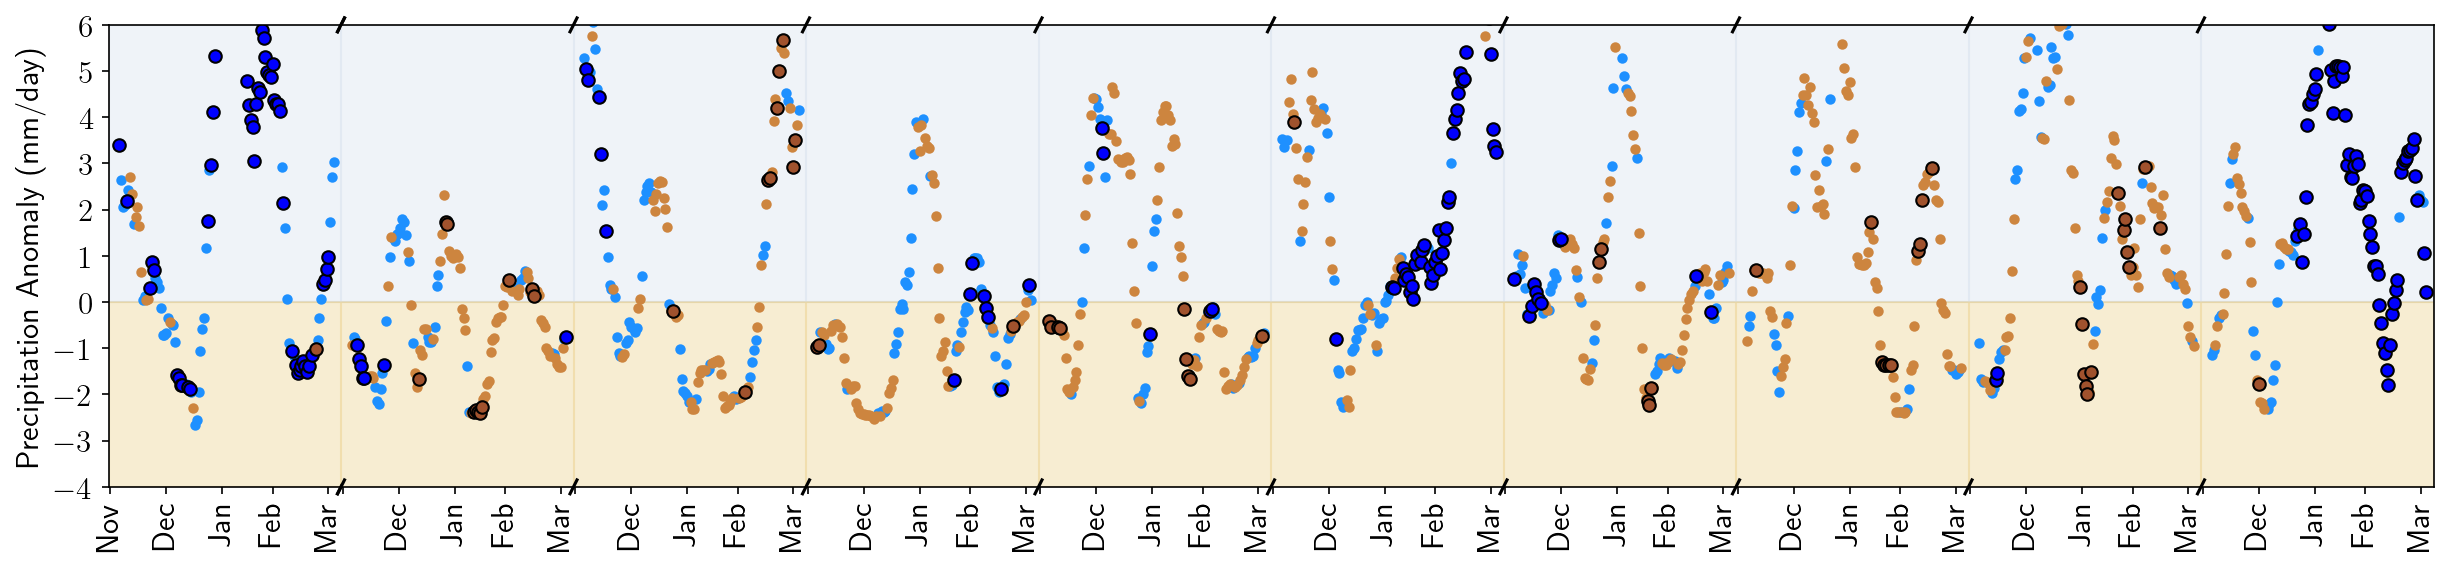

In [13]:
fig, (ax1,ax2, ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10) = plt.subplots(1,10, figsize=(20,4))
#ax1.plot(timeplot[120:480], np.zeros(len(timeplot[120:480])))
#ax1.plot(pos_pred.time,YtestP, color='grey', alpha=0.7)

ax1.plot(pos_pred.time, pos_pred, color='dodgerblue',marker='o', markersize='4', linestyle='none', label='Positive Prediction')
ax1.plot(neg_pred.time, neg_pred, color='peru',marker='o', markersize='4',linestyle='none', label='Negative Prediction')
ax2.plot(pos_pred.time, pos_pred, color='dodgerblue',marker='o', markersize='4', linestyle='none', label='Positive Prediction')
ax2.plot(neg_pred.time, neg_pred, color='peru',marker='o', markersize='4',linestyle='none', label='Negative Prediction')
ax3.plot(pos_pred.time, pos_pred, color='dodgerblue',marker='o', markersize='4', linestyle='none', label='Positive Prediction')
ax3.plot(neg_pred.time, neg_pred, color='peru',marker='o', markersize='4',linestyle='none', label='Negative Prediction')
ax4.plot(pos_pred.time, pos_pred, color='dodgerblue',marker='o', markersize='4', linestyle='none', label='Positive Prediction')
ax4.plot(neg_pred.time, neg_pred, color='peru',marker='o', markersize='4',linestyle='none', label='Negative Prediction')
ax5.plot(pos_pred.time, pos_pred, color='dodgerblue',marker='o', markersize='4', linestyle='none', label='Positive Prediction')
ax5.plot(neg_pred.time, neg_pred, color='peru',marker='o', markersize='4',linestyle='none', label='Negative Prediction')
ax6.plot(pos_pred.time, pos_pred, color='dodgerblue',marker='o', markersize='4', linestyle='none', label='Positive Prediction')
ax6.plot(neg_pred.time, neg_pred, color='peru',marker='o', markersize='4',linestyle='none', label='Negative Prediction')
ax7.plot(pos_pred.time, pos_pred, color='dodgerblue',marker='o', markersize='4', linestyle='none', label='Positive Prediction')
ax7.plot(neg_pred.time, neg_pred, color='peru',marker='o', markersize='4',linestyle='none', label='Negative Prediction')
ax8.plot(pos_pred.time, pos_pred, color='dodgerblue',marker='o', markersize='4', linestyle='none', label='Positive Prediction')
ax8.plot(neg_pred.time, neg_pred, color='peru',marker='o', markersize='4',linestyle='none', label='Negative Prediction')
ax9.plot(pos_pred.time, pos_pred, color='dodgerblue',marker='o', markersize='4', linestyle='none', label='Positive Prediction')
ax9.plot(neg_pred.time, neg_pred, color='peru',marker='o', markersize='4',linestyle='none', label='Negative Prediction')
ax10.plot(pos_pred.time, pos_pred, color='dodgerblue',marker='o', markersize='4', linestyle='none', label='Positive Prediction')
ax10.plot(neg_pred.time, neg_pred, color='peru',marker='o', markersize='4',linestyle='none', label='Negative Prediction')


ax1.plot(Y1_subset_pos.time, Y1_subset_pos, color='blue',marker='o', markeredgecolor = 'black', markersize='6',linestyle='none', label = 'Confident Positive Prediction')
ax1.plot(Y1_subset_neg.time, Y1_subset_neg, color='sienna',marker='o', markeredgecolor = 'black', markersize='6',linestyle='none', label = 'Confident Negative Prediction')
ax2.plot(Y1_subset_pos.time, Y1_subset_pos, color='blue',marker='o', markeredgecolor = 'black', markersize='6',linestyle='none', label = 'Confident Positive Prediction')
ax2.plot(Y1_subset_neg.time, Y1_subset_neg, color='sienna',marker='o', markeredgecolor = 'black', markersize='6',linestyle='none', label = 'Confident Negative Prediction')
ax3.plot(Y1_subset_pos.time, Y1_subset_pos, color='blue',marker='o', markeredgecolor = 'black', markersize='6',linestyle='none', label = 'Confident Positive Prediction')
ax3.plot(Y1_subset_neg.time, Y1_subset_neg, color='sienna',marker='o', markeredgecolor = 'black', markersize='6',linestyle='none', label = 'Confident Negative Prediction')
ax4.plot(Y1_subset_pos.time, Y1_subset_pos, color='blue',marker='o', markeredgecolor = 'black', markersize='6',linestyle='none', label = 'Confident Positive Prediction')
ax4.plot(Y1_subset_neg.time, Y1_subset_neg, color='sienna',marker='o', markeredgecolor = 'black', markersize='6',linestyle='none', label = 'Confident Negative Prediction')
ax5.plot(Y1_subset_pos.time, Y1_subset_pos, color='blue',marker='o', markeredgecolor = 'black', markersize='6',linestyle='none', label = 'Confident Positive Prediction')
ax5.plot(Y1_subset_neg.time, Y1_subset_neg, color='sienna',marker='o', markeredgecolor = 'black', markersize='6',linestyle='none', label = 'Confident Negative Prediction')
ax6.plot(Y1_subset_pos.time, Y1_subset_pos, color='blue',marker='o', markeredgecolor = 'black', markersize='6',linestyle='none', label = 'Confident Positive Prediction')
ax6.plot(Y1_subset_neg.time, Y1_subset_neg, color='sienna',marker='o', markeredgecolor = 'black', markersize='6',linestyle='none', label = 'Confident Negative Prediction')
ax7.plot(Y1_subset_pos.time, Y1_subset_pos, color='blue',marker='o', markeredgecolor = 'black', markersize='6',linestyle='none', label = 'Confident Positive Prediction')
ax7.plot(Y1_subset_neg.time, Y1_subset_neg, color='sienna',marker='o', markeredgecolor = 'black', markersize='6',linestyle='none', label = 'Confident Negative Prediction')
ax8.plot(Y1_subset_pos.time, Y1_subset_pos, color='blue',marker='o', markeredgecolor = 'black', markersize='6',linestyle='none', label = 'Confident Positive Prediction')
ax8.plot(Y1_subset_neg.time, Y1_subset_neg, color='sienna',marker='o', markeredgecolor = 'black', markersize='6',linestyle='none', label = 'Confident Negative Prediction')
ax9.plot(Y1_subset_pos.time, Y1_subset_pos, color='blue',marker='o', markeredgecolor = 'black', markersize='6',linestyle='none', label = 'Confident Positive Prediction')
ax9.plot(Y1_subset_neg.time, Y1_subset_neg, color='sienna',marker='o', markeredgecolor = 'black', markersize='6',linestyle='none', label = 'Confident Negative Prediction')
ax10.plot(Y1_subset_pos.time, Y1_subset_pos, color='blue',marker='o', markeredgecolor = 'black', markersize='6',linestyle='none', label = 'Confident Positive Prediction')
ax10.plot(Y1_subset_neg.time, Y1_subset_neg, color='sienna',marker='o', markeredgecolor = 'black', markersize='6',linestyle='none', label = 'Confident Negative Prediction')


ax1.axhspan(0, 6, alpha=0.2, color='lightsteelblue')
ax1.axhspan(-4, 0, alpha=0.2, color='goldenrod')
ax2.axhspan(0, 6, alpha=0.2, color='lightsteelblue')
ax2.axhspan(-4, 0, alpha=0.2, color='goldenrod')
ax3.axhspan(0, 6, alpha=0.2, color='lightsteelblue')
ax3.axhspan(-4, 0, alpha=0.2, color='goldenrod')
ax4.axhspan(0, 6, alpha=0.2, color='lightsteelblue')
ax4.axhspan(-4, 0, alpha=0.2, color='goldenrod')
ax5.axhspan(0, 6, alpha=0.2, color='lightsteelblue')
ax5.axhspan(-4, 0, alpha=0.2, color='goldenrod')
ax6.axhspan(0, 6, alpha=0.2, color='lightsteelblue')
ax6.axhspan(-4, 0, alpha=0.2, color='goldenrod')
ax7.axhspan(0, 6, alpha=0.2, color='lightsteelblue')
ax7.axhspan(-4, 0, alpha=0.2, color='goldenrod')
ax8.axhspan(0, 6, alpha=0.2, color='lightsteelblue')
ax8.axhspan(-4, 0, alpha=0.2, color='goldenrod')
ax9.axhspan(0, 6, alpha=0.2, color='lightsteelblue')
ax9.axhspan(-4, 0, alpha=0.2, color='goldenrod')
ax10.axhspan(0, 6, alpha=0.2, color='lightsteelblue')
ax10.axhspan(-4, 0, alpha=0.2, color='goldenrod')

ax1.set(ylabel = 'Precipitation Anomaly (mm/day)')
ax1.set(ylim=(-4,6))
ax1.set_yticks([-4,-3,-2,-1,0,1,2,3,4,5,6])
ax2.set(ylim=(-4,6))
ax3.set(ylim=(-4,6))
ax4.set(ylim=(-4,6))
ax5.set(ylim=(-4,6))
ax6.set(ylim=(-4,6))
ax7.set(ylim=(-4,6))
ax8.set(ylim=(-4,6))
ax9.set(ylim=(-4,6))
ax10.set(ylim=(-4,6))

ax2.set_yticks([])
ax3.set_yticks([])
ax4.set_yticks([])
ax5.set_yticks([])
ax6.set_yticks([])
ax7.set_yticks([])
ax8.set_yticks([])
ax9.set_yticks([])
ax10.set_yticks([])

ax1.set(xlim=(cftime.DatetimeNoLeap(1875, 11, 30),cftime.DatetimeNoLeap(1876, 4, 8)))
ax2.set(xlim=(cftime.DatetimeNoLeap(1876, 11, 30),cftime.DatetimeNoLeap(1877, 4, 8)))
ax3.set(xlim=(cftime.DatetimeNoLeap(1877, 11, 30),cftime.DatetimeNoLeap(1878, 4, 8)))
ax4.set(xlim=(cftime.DatetimeNoLeap(1878, 11, 30),cftime.DatetimeNoLeap(1879, 4, 8)))
ax5.set(xlim=(cftime.DatetimeNoLeap(1879, 11, 30),cftime.DatetimeNoLeap(1880, 4, 8)))
ax6.set(xlim=(cftime.DatetimeNoLeap(1880, 11, 30),cftime.DatetimeNoLeap(1881, 4, 8)))
ax7.set(xlim=(cftime.DatetimeNoLeap(1881, 11, 30),cftime.DatetimeNoLeap(1882, 4, 8)))
ax8.set(xlim=(cftime.DatetimeNoLeap(1882, 11, 30),cftime.DatetimeNoLeap(1883, 4, 8)))
ax9.set(xlim=(cftime.DatetimeNoLeap(1883, 11, 30),cftime.DatetimeNoLeap(1884, 4, 8)))
ax10.set(xlim=(cftime.DatetimeNoLeap(1884, 11, 30),cftime.DatetimeNoLeap(1885, 4, 8)))


ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax5.spines['left'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax6.spines['left'].set_visible(False)
ax6.spines['right'].set_visible(False)
ax7.spines['right'].set_visible(False)
ax7.spines['left'].set_visible(False)
ax8.spines['left'].set_visible(False)
ax8.spines['right'].set_visible(False)
ax9.spines['right'].set_visible(False)
ax9.spines['left'].set_visible(False)
ax10.spines['left'].set_visible(False)

# xticklabels1= ['Nov 1875','','Jan 1876','','','']
# xticklabels2= ['Nov 1876','','Jan 1877','','','']
# xticklabels3= ['Nov 1877','','Jan 1878','','','']
# xticklabels4= ['Nov 1878','','Jan 1879','','','']
# xticklabels5= ['Nov 1879','','Jan 1880','','','']
# xticklabels6= ['Nov 1880','','Jan 1881','','','']
# xticklabels7= ['Nov 1881','','Jan 1882','','','']
# xticklabels8= ['Nov 1882','','Jan 1883','','','']
# xticklabels9= ['Nov 1883','','Jan 1884','','','']
# xticklabels10= ['Nov 1884','','Jan 1885','','','']

# ax1.set_xticklabels(xticklabels1, rotation = 45)
# ax2.set_xticklabels(xticklabels2, rotation = 45)
# ax3.set_xticklabels(xticklabels3, rotation = 45)
# ax4.set_xticklabels(xticklabels4, rotation = 45)
# ax5.set_xticklabels(xticklabels5, rotation = 45)
# ax6.set_xticklabels(xticklabels6, rotation = 45)
# ax7.set_xticklabels(xticklabels7, rotation = 45)
# ax8.set_xticklabels(xticklabels8, rotation = 45)
# ax9.set_xticklabels(xticklabels9, rotation = 45)
# ax10.set_xticklabels(xticklabels10, rotation = 45)

xticklabels= ['Nov','Dec','Jan','Feb','Mar','']
xticklabels1= ['','Dec','Jan','Feb','Mar','']

rotation = 90
ax1.set_xticklabels(xticklabels, rotation = rotation)
ax2.set_xticklabels(xticklabels1, rotation = rotation)
ax3.set_xticklabels(xticklabels1, rotation = rotation)
ax4.set_xticklabels(xticklabels1, rotation = rotation)
ax5.set_xticklabels(xticklabels1, rotation = rotation)
ax6.set_xticklabels(xticklabels1, rotation = rotation)
ax7.set_xticklabels(xticklabels1, rotation = rotation)
ax8.set_xticklabels(xticklabels1, rotation = rotation)
ax9.set_xticklabels(xticklabels1, rotation = rotation)
ax10.set_xticklabels(xticklabels1, rotation = rotation)

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d, 1+d), (-d, +d), **kwargs)
ax1.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1-d, 1+d), **kwargs)
ax2.plot((-d, +d), (-d, +d), **kwargs)
kwargs.update(transform=ax3.transAxes)  # switch to the bottom axes
ax3.plot((-d, +d), (1-d, 1+d), **kwargs)
ax3.plot((-d, +d), (-d, +d), **kwargs)
kwargs.update(transform=ax4.transAxes)  # switch to the bottom axes
ax4.plot((-d, +d), (1-d, 1+d), **kwargs)
ax4.plot((-d, +d), (-d, +d), **kwargs)
kwargs.update(transform=ax5.transAxes)  # switch to the bottom axes
ax5.plot((-d, +d), (1-d, 1+d), **kwargs)
ax5.plot((-d, +d), (-d, +d), **kwargs)
kwargs.update(transform=ax6.transAxes)  # switch to the bottom axes
ax6.plot((-d, +d), (1-d, 1+d), **kwargs)
ax6.plot((-d, +d), (-d, +d), **kwargs)
kwargs.update(transform=ax7.transAxes)  # switch to the bottom axes
ax7.plot((-d, +d), (1-d, 1+d), **kwargs)
ax7.plot((-d, +d), (-d, +d), **kwargs)
kwargs.update(transform=ax8.transAxes)  # switch to the bottom axes
ax8.plot((-d, +d), (1-d, 1+d), **kwargs)
ax8.plot((-d, +d), (-d, +d), **kwargs)
kwargs.update(transform=ax9.transAxes)  # switch to the bottom axes
ax9.plot((-d, +d), (1-d, 1+d), **kwargs)
ax9.plot((-d, +d), (-d, +d), **kwargs)
kwargs.update(transform=ax10.transAxes)  # switch to the bottom axes
ax10.plot((-d, +d), (1-d, 1+d), **kwargs)
ax10.plot((-d, +d), (-d, +d), **kwargs)


plt.subplots_adjust(wspace=0.00)
